# Latvian Leaflets — Monthly Frequency of a Lemmatized Word (Stanza)

This notebook lets you:
1) Upload a **ZIP** with your leaflet `.txt` files (each file contains metadata and a `text:` block).
2) Choose a **lemma** to track (e.g., `fašisms`).
3) Optionally list **manual variant forms** to force-map to that lemma (safety net for declension forms).
4) Compute **absolute monthly frequencies** of that lemma (no stopword removal; everything is lemmatized).
5) Plot a **monthly frequency chart**.

**Date handling** in metadata (`date:`):
- Exact date: `YYYY-MM-DD` or month `YYYY-MM`.
- Interval: `[YYYY-MM-DD..YYYY-MM-DD]` (also supports Unicode ellipsis `…`). We assign the **midpoint date** to a month.
- Not earlier than: `[YYYY-MM-DD…]` → assigned to the **boundary date** (the given date).
- Not later than: `[…YYYY-MM-DD]` → assigned to the **boundary date** (the given date).
- Unknown `[.]` → **skipped**.

If you prefer a different rule later (e.g., spread counts proportionally across months), we can add it as an option; here we keep it **simple and deterministic**.

In [ ]:
#@title 1) Install and import libraries
!pip -q install stanza==1.6.1 pandas matplotlib tqdm

import os, re, zipfile, io
from collections import Counter, defaultdict
from datetime import datetime, date, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import stanza

try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

print('IN_COLAB:', IN_COLAB)

IN_COLAB: True


In [ ]:
#@title 2) Set your target lemma and manual forms
target_lemma = 'fašisms'  # canonical lemma to count

# all forms mapped to 'fašisms'
manual_forms = [
    'fašisms', 'fašisma', 'fašismam', 'fašismu', 'fašismā',
    'fašismi', 'fašismu', 'fašismiem', 'fašismus', 'fašismos',
    'fašists', 'fašista', 'fašistam', 'fašistu', 'fašistā',
    'fašisti', 'fašistiem', 'fašistus', 'fašistos',
    'fašiste', 'fašistes', 'fašistei', 'fašisti', 'fašistē',
    'fašistes', 'fašistēm', 'fašistēs',
    'fašistisks', 'fašistiska', 'fašistiskam', 'fašistisku', 'fašistiskā',
    'fašistiski', 'fašistiskiem', 'fašistiskus', 'fašistiskos',
    'fašistiskas', 'fašistiskām', 'fašistiskās',
    'fašistiskāks', 'fašistiskāka', 'fašistiskāki', 'fašistiskākas',
    'visfašistiskākais', 'visfašistiskākā', 'visfašistiskākie', 'visfašistiskākās'
]

print('Target lemma:', target_lemma)
print('Manual forms:', manual_forms)

Target lemma: fašisms
Manual forms: ['fašisms', 'fašisma', 'fašismam', 'fašismu', 'fašismā', 'fašismi', 'fašismu', 'fašismiem', 'fašismus', 'fašismos', 'fašists', 'fašista', 'fašistam', 'fašistu', 'fašistā', 'fašisti', 'fašistiem', 'fašistus', 'fašistos', 'fašiste', 'fašistes', 'fašistei', 'fašisti', 'fašistē', 'fašistes', 'fašistēm', 'fašistēs', 'fašistisks', 'fašistiska', 'fašistiskam', 'fašistisku', 'fašistiskā', 'fašistiski', 'fašistiskiem', 'fašistiskus', 'fašistiskos', 'fašistiskas', 'fašistiskām', 'fašistiskās', 'fašistiskāks', 'fašistiskāka', 'fašistiskāki', 'fašistiskākas', 'visfašistiskākais', 'visfašistiskākā', 'visfašistiskākie', 'visfašistiskākās']


In [ ]:
#@title 3) Upload the ZIP with leaflets and extract
leaflet_dir = 'leaflets'  # folder to unpack
if os.path.exists(leaflet_dir):
    # clean up old run
    import shutil
    shutil.rmtree(leaflet_dir)
os.makedirs(leaflet_dir, exist_ok=True)

if IN_COLAB:
    print('Please select your ZIP file with leaflet .txt files...')
    uploaded = files.upload()  # opens a browser dialog in Colab
    if not uploaded:
        raise RuntimeError('No file uploaded.')
    fname = list(uploaded.keys())[0]
    data = uploaded[fname]
else:
    # If running locally, set a path to your ZIP here
    fname = 'leaflets.zip'  # change this to your local path
    with open(fname, 'rb') as f:
        data = f.read()

with zipfile.ZipFile(io.BytesIO(data)) as z:
    z.extractall(leaflet_dir)

# Count .txt files
txt_files = []
for root, _, files_list in os.walk(leaflet_dir):
    for fn in files_list:
        if fn.lower().endswith('.txt'):
            txt_files.append(os.path.join(root, fn))
print(f'Extracted {len(txt_files)} text files.')


Please select your ZIP file with leaflet .txt files...


Saving latvian_communist_leaflets_1934-1940.zip to latvian_communist_leaflets_1934-1940 (2).zip
Extracted 127 text files.


In [ ]:
#@title 4) Download/initialize Stanza for Latvian
stanza.download('lv')
nlp = stanza.Pipeline(lang='lv', processors='tokenize,lemma', tokenize_no_ssplit=True)

INFO:stanza:Downloading default packages for language: lv (Latvian) ...
INFO:stanza:File exists: /root/stanza_resources/lv/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: lv (Latvian):
| Processor | Package       |
-----------------------------
| tokenize  | lvtb          |
| lemma     | lvtb_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [ ]:
#@title 5) Helpers: parse metadata & dates, lemmatize and count
import re
from datetime import datetime, date, timedelta

DATE_LINE_RE = re.compile(r'^\s*date\s*:\s*(.+)$', flags=re.IGNORECASE | re.MULTILINE)
PRINT_RUN_RE = re.compile(r'^\s*print_run\s*:\s*(.+)$', flags=re.IGNORECASE | re.MULTILINE)
TEXT_MARK_RE = re.compile(r'^\s*text\s*:\s*$', flags=re.IGNORECASE | re.MULTILINE)
TEXT_INLINE_RE = re.compile(r'^\s*text\s*:\s*(.+)$', flags=re.IGNORECASE | re.MULTILINE | re.DOTALL)

def extract_date_str(content: str):
    m = DATE_LINE_RE.search(content)
    return m.group(1).strip() if m else None

def extract_print_run(content: str):
    """Return print run as int if parsable; 'unk' or missing → None."""
    m = PRINT_RUN_RE.search(content)
    if not m:
        return None
    raw = m.group(1).strip().lower()
    if raw == 'unk':
        return None
    digits = re.sub(r'[^0-9]', '', raw)
    try:
        return int(digits) if digits else None
    except Exception:
        return None

def extract_text_body(content: str):
    # Try 'text:' on its own line → everything after
    m = TEXT_MARK_RE.search(content)
    if m:
        return content[m.end():].strip()
    # Or 'text: <inline>'
    m2 = TEXT_INLINE_RE.search(content)
    if m2:
        return m2.group(1).strip()
    return ''

def parse_bracketed_date(date_str: str):
    """Parse bracketed forms.
    Rules:
      - [start..end] → midpoint date
      - [start…]     → start
      - […end]       → end
      - [.]          → None
      - [YYYY-MM-DD] / [YYYY-MM] → exact; month → last day of month
    """
    s = date_str.strip()
    if s == '[.]':
        return None
    s_norm = s.replace('…', '..')
    inner = s_norm[1:-1].strip() if s_norm.startswith('[') and s_norm.endswith(']') else s_norm

    # [start..end]
    if '..' in inner and not inner.startswith('..') and not inner.endswith('..'):
        start_str, end_str = [x.strip() for x in inner.split('..', 1)]
        try:
            start = datetime.strptime(start_str, '%Y-%m-%d').date()
            end = datetime.strptime(end_str, '%Y-%m-%d').date()
            mid = start + (end - start) / 2
            return date.fromtimestamp(mid.timestamp())
        except Exception:
            return None

    # [start..]
    if inner.endswith('..') and not inner.startswith('..'):
        start_str = inner[:-2].strip()
        for fmt in ('%Y-%m-%d', '%Y-%m'):
            try:
                dt = datetime.strptime(start_str, fmt)
                if fmt == '%Y-%m':
                    return date(dt.year, dt.month, 1)
                return dt.date()
            except Exception:
                pass
        return None

    # [..end]
    if inner.startswith('..') and not inner.endswith('..'):
        end_str = inner[2:].strip()
        for fmt in ('%Y-%m-%d', '%Y-%m'):
            try:
                dt = datetime.strptime(end_str, fmt)
                if fmt == '%Y-%m':
                    year, month = dt.year, dt.month
                    if month == 12:
                        return date(year, 12, 31)
                    next_month = date(year, month + 1, 1)
                    return next_month - timedelta(days=1)
                return dt.date()
            except Exception:
                pass
        return None

    # Exact date or month
    for fmt in ('%Y-%m-%d', '%Y-%m'):
        try:
            dt = datetime.strptime(inner, fmt)
            if fmt == '%Y-%m':
                year, month = dt.year, dt.month
                if month == 12:
                    return date(year, 12, 31)
                next_month = date(year, month + 1, 1)
                return next_month - timedelta(days=1)
            return dt.date()
        except Exception:
            pass
    return None

def parse_any_date(date_str: str):
    if not date_str:
        return None
    s = date_str.strip()
    if s.startswith('['):
        return parse_bracketed_date(s)
    for fmt in ('%Y-%m-%d', '%Y-%m'):
        try:
            dt = datetime.strptime(s, fmt)
            if fmt == '%Y-%m':
                year, month = dt.year, dt.month
                if month == 12:
                    return date(year, 12, 31)
                next_month = date(year, month + 1, 1)
                return next_month - timedelta(days=1)
            return dt.date()
        except Exception:
            pass
    return None

manual_set = set(x.lower() for x in manual_forms)
target_lower = target_lemma.lower()

def count_target_in_text(txt: str) -> int:
    # Tokenize + lemmatize with Stanza; no stopword removal.
    doc = nlp(txt)
    cnt = 0
    for sent in doc.sentences:
        for w in sent.words:
            token_lower = (w.text or '').lower()
            if token_lower in manual_set:
                lemma = target_lower
            else:
                lemma = (w.lemma or w.text or '').lower()
            if lemma == target_lower:
                cnt += 1
    return cnt


In [ ]:
#@title 5A) Compute DEFAULT_WEIGHT_FOR_UNK (median of known print_run)
from statistics import median

known_print_runs = []

for path in sorted(txt_files):
    # читаем файл (как в обработчике — с запасом по кодировкам)
    try:
        with open(path, 'r', encoding='utf-8', errors='replace') as f:
            content = f.read()
    except Exception:
        with open(path, 'r', encoding='latin-1', errors='replace') as f:
            content = f.read()

    pr = extract_print_run(content)  # int или None
    if pr is not None:
        known_print_runs.append(pr)

if known_print_runs:
    DEFAULT_WEIGHT_FOR_UNK = int(median(known_print_runs))
else:
    DEFAULT_WEIGHT_FOR_UNK = 500  # фолбэк, если вообще нет известных тиражей

print(f"DEFAULT_WEIGHT_FOR_UNK = {DEFAULT_WEIGHT_FOR_UNK}  (based on {len(known_print_runs)} known print_run values)")

DEFAULT_WEIGHT_FOR_UNK = 3000  (based on 95 known print_run values)


In [ ]:
#@title Share of unknown files
import numpy as np

q1, q2, q3 = np.quantile(known_print_runs, [0.25, 0.5, 0.75])
print("Q1, median, Q3:", q1, q2, q3)
share_unk = 1 - len(known_print_runs)/len(txt_files)
print(f"Share of UNK files: {share_unk:.1%}")

Q1, median, Q3: 1000.0 3000.0 4000.0
Share of UNK files: 25.2%


In [ ]:
#@title Optional override for unknown print_run
DEFAULT_WEIGHT_FOR_UNK = 500   # ← поставь 500/1000/3000 по своему сценарию
print("Override DEFAULT_WEIGHT_FOR_UNK =", DEFAULT_WEIGHT_FOR_UNK)

Override DEFAULT_WEIGHT_FOR_UNK = 500


In [ ]:
#@title 6) Process all files → monthly absolute counts (unweighted & weighted)
from collections import Counter
from tqdm import tqdm
import os

month_counts = Counter()            # unweighted: raw occurrences
month_weighted_counts = Counter()   # weighted by print_run
skipped_no_date = 0
unknown_print_run_files = 0
files_with_counts = []  # (file_name, month, raw_count, print_run, weighted_count)

for path in tqdm(sorted(txt_files)):
    # Read
    try:
        with open(path, 'r', encoding='utf-8', errors='replace') as f:
            content = f.read()
    except Exception:
        with open(path, 'r', encoding='latin-1', errors='replace') as f:
            content = f.read()

    # Date
    dstr = extract_date_str(content)
    d = parse_any_date(dstr) if dstr else None
    if not d:
        skipped_no_date += 1
        continue
    month_key = f"{d.year:04d}-{d.month:02d}"

    # Text & count
    body = extract_text_body(content)
    c = count_target_in_text(body)

    # Print run → weight (unk → 500)
    pr = extract_print_run(content)
    if pr is None:
        unknown_print_run_files += 1
        weight = DEFAULT_WEIGHT_FOR_UNK  # default when print_run is unknown - you can choose your own (e.g. 500). Now it's a median among all leaflets.
    else:
        weight = pr

    # Aggregate
    if c:
        month_counts[month_key] += c
        month_weighted_counts[month_key] += c * weight

    files_with_counts.append((os.path.basename(path), month_key, c, pr, c * weight))

print('Files with no determinable date skipped:', skipped_no_date)
print('Files with unknown print_run (treated as weight=500):', unknown_print_run_files)
len(files_with_counts)


100%|██████████| 127/127 [01:09<00:00,  1.83it/s]

Files with no determinable date skipped: 6
Files with unknown print_run (treated as weight=500): 30


121

In [ ]:
#@title 7) Build a tidy DataFrame (continuous months) and plot
import pandas as pd

def build_month_range(keys):
    if not keys:
        return []
    months_sorted = sorted(keys)
    start_year, start_month = map(int, months_sorted[0].split('-'))
    end_year, end_month = map(int, months_sorted[-1].split('-'))
    y, m = start_year, start_month
    out = []
    while True:
        out.append(f"{y:04d}-{m:02d}")
        if y == end_year and m == end_month:
            break
        m += 1
        if m == 13:
            y += 1
            m = 1
    return out

all_months = set(month_counts) | set(month_weighted_counts)
ym_list = build_month_range(all_months) if all_months else []

data = pd.DataFrame({
    'month': ym_list,
    'abs_frequency': [month_counts.get(ym, 0) for ym in ym_list],
    'abs_frequency_weighted': [month_weighted_counts.get(ym, 0) for ym in ym_list]
})

data.head(), data.tail()


(     month  abs_frequency  abs_frequency_weighted
 0  1934-01             46                   71500
 1  1934-02             31                  157500
 2  1934-03             36                   66500
 3  1934-04             58                  255900
 4  1934-05             61                  115000,
       month  abs_frequency  abs_frequency_weighted
 10  1934-11             44                  163000
 11  1934-12              8                    8000
 12  1935-01             75                  162500
 13  1935-02             68                  131000
 14  1935-03             27                   80000)

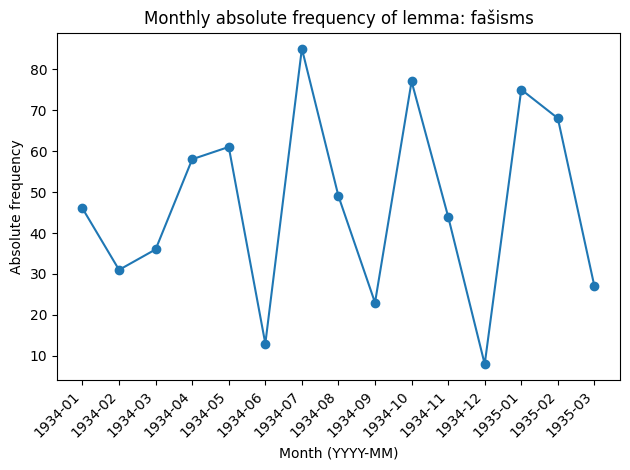

In [ ]:
#@title 8) Plot absolute monthly frequency (Matplotlib)
plt.figure()
plt.plot(data['month'], data['abs_frequency'], marker='o')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Month (YYYY-MM)')
plt.ylabel('Absolute frequency')
plt.title(f"Monthly absolute frequency of lemma: {target_lemma}")
plt.tight_layout()
plt.show()

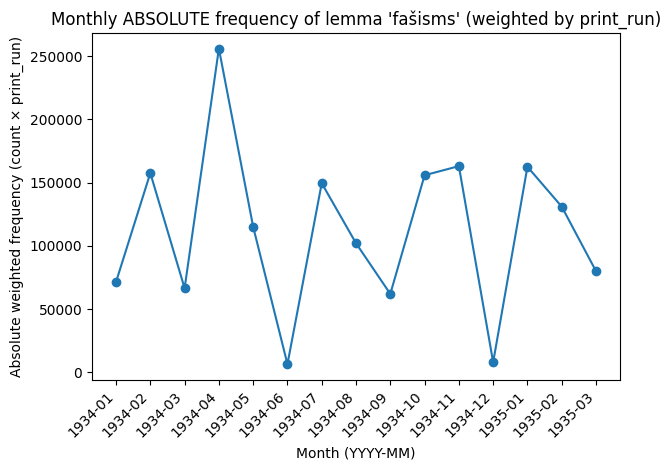

In [ ]:
#@title 9) Plot ABSOLUTE monthly frequency (weighted by print_run)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(data['month'], data['abs_frequency_weighted'], marker='o')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Month (YYYY-MM)')
plt.ylabel('Absolute weighted frequency (count × print_run)')
plt.title(f"Monthly ABSOLUTE frequency of lemma '{target_lemma}' (weighted by print_run)")
plt.tight_layout()
plt.show()


In [ ]:
#@title 10) Show per-file contributions (optional)
df_files = pd.DataFrame(files_with_counts, columns=['file_name', 'month', 'count_in_file', 'print_run', 'weighted_count_in_file'])
df_files.sort_values(['month', 'count_in_file'], ascending=[True, False]).head(10)

,file_name,month,count_in_file,print_run,weighted_count_in_file
2,revl-n003-SP_CK-unk-[…1934-01-21].txt,1934-01,13,NaN,6500
7,revl-n007-SP_Riga_committee-unk-1934-01.txt,1934-01,13,NaN,6500
3,revl-n004a-LKP_CK-3000-[…1934-01-30].txt,1934-01,5,3000.0,15000
1,revl-n002-LKP_soldiers_org-1500-[1934-01-11…].txt,1934-01,4,1500.0,6000
5,revl-n005-LKP_CK_LKJS_CK-5000-1934-01.txt,1934-01,4,5000.0,20000
8,revl-n008-SP_Riga_committee-unk-1934-01.txt,1934-01,3,NaN,1500
0,revl-n001-LKP_LKJS_Vidienas_org-5000-[1934-01-...,1934-01,2,5000.0,10000
6,revl-n006-LKJS_Riga_committee-3000-1934-01.txt,1934-01,2,3000.0,6000
14,revl-n014-LKJS_CK-4000-1934-02-26.txt,1934-02,10,4000.0,40000
11,revl-n011-LKP_Riga_committee-6000-[…1934-02-12...,1934-02,9,6000.0,54000


### Notes

- **What is shown here**
  - `abs_frequency`  = ∑ lemma hits per calendar month (unweighted).
  - `abs_frequency_weighted` = ∑ (lemma hits × print_run) per calendar month.
  - Unweighted reflects **how often the lemma appears in surviving texts**; weighted approximates **audience reach** by factoring in print runs.

- **Lemmatization & counting**
  - Language: Latvian via **Stanza** (version pinned in the install cell).
  - No stopword removal: we count all occurrences of the target lemma.
  - Manual mapping (`manual_forms`) is **case-insensitive** and applied **before** comparing to the target lemma (use it to force variants/adjectives to the same lemma).

- **Print runs**
  - Weight = `print_run` when available; for unknown values we use `DEFAULT_WEIGHT_FOR_UNK`.
  - `DEFAULT_WEIGHT_FOR_UNK` is computed in cell **5A** (median of known print runs), and can be overridden (e.g., 500 / 1000) with a small override cell.

- **Dates**
  - Exact `YYYY-MM-DD` goes to that month; `YYYY-MM` uses the **last day of month** to bucket.
  - Intervals `[start..end]` use the **midpoint**; `[start…]` (“not earlier than”) and `[…end]` (“not later than”) use the **boundary date**.
  - `[.]` (unreadable) is skipped.
  - Aggregation is by **calendar month** (no normalization by month length).

- **Caveats**
  - A higher share of unknown print runs makes the weighted series **sensitive** to your chosen default; consider a brief sensitivity check (e.g., 500 vs 1000 vs median).
  - Midpointing intervals can shift some counts between adjacent months.
  - Because this notebook reports **absolute counts**, it is affected by how many texts survive for a month; use the relative notebook when you need normalization by total text volume.

- **Easy tweaks**
  - Add a companion plot with both lines (unweighted vs weighted) for side-by-side comparison.
  - Apply smoothing (e.g., 3-month moving average) to reduce volatility.
  - Break down by author/organization or by year, or combine multiple lemmas into one chart.